## 构建一个RAG应用
> RAG：Retrieval Augmented Generation

**官方文档：** https://python.langchain.com/docs/tutorials/rag/

**特别声明：** 本教程旨在跑通整个链路，模型效果暂不纳入考虑
### 整体方案
构建一个RAG简单应用主要包含两部分：文档索引和查询生成
1. 文档索引：构建知识文本索引，方便快速获取相似/相关文档。一般是离线的数据链路。
2. 获取并生成结果：实时获取相关文本并传给LLM，生成最终结果。

#### 技术方案
- Ollama + Chroma + LangChain：说明Ollama是本地运行大模型的框架；Chroma是向量数据库
- Embedding Model：nomic-embed-text（一个基于Sentence Transformers库的句子嵌入模型，专门用于特征提取和句子相似度计算）
- Chat Model：

LangChain相关库：langchain-ollama、langchain-chroma。安装指令：`pip install langchain-ollama langchain-chroma`

### 第一部分：构建文档索引
详见：03.langchain-vector-store

### 第二部分：查询生成
核心步骤：
1. 构建LLM模型实例
2. 构建Prompt Template
3. 构建Chain
4. 测试问题

LangChain提示词模板库：https://smith.langchain.com/hub

#### 第一步：初始化系统变量
主要包括2块：
- LANGSMITH_*: LangSmith相关的参数。
    - LANGSMITH_TRACING: 是否开启LangSmith追踪的开关
    - LANGSMITH_ENDPOINT: LangSmith平台访问URL
    - LANGSMITH_API_KEY: 访问LangSmith接口的API Key
    - LANGSMITH_PROJECT: 项目唯一标识
- DEEPSEEK_API_KEY: 访问DeepSeek大模型接口的API Key

In [1]:
import os
import getpass

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "langchain-study-rag"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("请输入LangSmith API KEY：")
os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("请输入DeepSeek API KEY：")

请输入DeepSeek API KEY： ········


#### 第二步：构建LangGraph
##### 问题集合
1. HumanMessage、SystemMessage、ToolMessage这些消息是怎么组织并发给大模型的？
2. StateGraph的原理
3. LangGraph Platform的作用

##### 构建LangGraph需要定义三个东西
1. 应用的State：应用的输入和输出，以及控制流中各节点的输入和输出，一般情况下是TypedDict，也可以是[Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/)。
2. 应用的节点：
3. 应用的控制流：

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document

from langchain_deepseek import ChatDeepSeek
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma

from langgraph.graph import START, END, StateGraph

from typing_extensions import List, TypedDict


embeddings = OllamaEmbeddings(model="nomic-embed-text")
vector_store = Chroma(
    collection_name="supply-chain-knowledge-vectors",
    embedding_function=embeddings,
    persist_directory="./.chroma_db"
)

prompt = ChatPromptTemplate([
    ("system", "你是一名资深供应链计划专家"),
    ("human", "相关领域知识:{knowledge} \n\n 问题:{question}")
])

chat_model = ChatDeepSeek(
    model="deepseek-chat",
    temperature=1.0,
    max_retries=2
)

class State(TypedDict):
    documents: List[Document]
    question: str
    answer: str

# 从向量数据库获取知识文档集
def retrieve(state: State):
    documents = vector_store.similarity_search(state["question"])
    return {"documents": documents}

# 请求大模型
def generate(state: State):
    documents_content = "\n\n".join(document.page_content for document in state["documents"])
    messages = prompt.invoke({"question": state["question"], "knowledge": documents_content})
    response = chat_model.invoke(messages)
    return {"answer": response.content}

# 构建LangGraph
group_builder = StateGraph(State)
group_builder.add_node("retrieve", retrieve)
group_builder.add_node("generate", generate)
group_builder.add_edge(START, "retrieve")
group_builder.add_edge("retrieve", "generate")
group_builder.add_edge("generate", END)

rag_app = group_builder.compile()

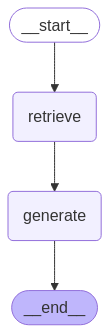

In [3]:
from IPython.display import Image, display

display(Image(rag_app.get_graph().draw_mermaid_png()))

In [5]:
for step in rag_app.stream({"question": "请问IBP是什么"}, stream_mode="updates"):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'documents': [Document(id='9c85ce3b-5209-423e-83d1-4322176eb1d4', metadata={'row': 7, 'source': './knowledge-documents.csv'}, page_content='知识项: IBP不仅是规划工具，更是战略管理平台，通过整合数据、流程与文化，帮助企业实现从被动响应到主动规划的数字化转型。其核心价值在于提升敏捷性、优化资源配置，从而在动态市场中保持竞争力。'), Document(id='d91057e2-ceef-40f6-81c1-8bf33a3d0443', metadata={'row': 6, 'source': './knowledge-documents.csv'}, page_content='知识项: IBP（集成业务计划，Integrated Business Planning）是一种战略性、跨职能的业务规划方法，旨在通过整合企业内部的战略、财务、运营等环节，实现资源优化和高效协同。IBP的定义与内涵：滚动规划计划、三位一体整合。IBP的核心目标：战略与执行对齐、动态响应市场变化、资源优化与成本控制。IBP的实施流程：数据整合与统一视图、跨部门协作与决策、动态优化与模拟分析。'), Document(id='a93025f8-f3df-4be6-a91e-f16ce1c5ecf4', metadata={'row': 3, 'source': './knowledge-documents.csv'}, page_content='知识项: 库存计划的实现方案有：基于预测的库存计划、ABC分类法、经济订货批量（EOQ）模型、供应商管理库存（VMI）、联合库存管理（JMI）、寄售库存。基于预测的库存计划涉及一些重要的参数：再订货点、目标库存水位、Smin/Smax、安全库存。'), Document(id='03becd8b-d0b2-44aa-a4f1-95e9ea1aa07a', metadata={'row': 4, 'source': './knowledge-documents.csv'}, page_content='知识项: S&OP是一种将销售、运营、财务等多部门计划进行整合的管理流程。它通过对市

#### 延伸阅读
1. Query分析：https://python.langchain.com/docs/how_to/#query-analysis
2. 检索：https://python.langchain.com/docs/concepts/retrieval
3. 